In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
import os
import cv2
from itertools import combinations
from PIL import Image


2024-04-09 08:23:53.895732: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-09 08:23:53.895857: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-09 08:23:54.167655: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
dirct = "/kaggle/input/datascientists-signtures/Deep learning dataset_cleaned"

In [3]:
# image_files = os.listdir(data_dir)
target_size = (100,100)

def load_raw_data(path, target_size):
    students = os.listdir(path)
    
    pairs = []
    labels = []
    
    for student in students:
        forged_images = []
        original_images = []
        
        student_path = os.path.join(path, student) # contains forged, original folders
        student_folders = os.listdir(student_path)
        i=0
        for folder_name in student_folders:
            folder_dir = os.path.join(student_path, folder_name) # contains images
            
            if os.path.isdir(folder_dir):
                for img_name in os.listdir(folder_dir):
                    img_path = os.path.join(folder_dir, img_name)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, target_size)
                    img = np.reshape(img, (*target_size, 1))
                    
                    if i == 0 : # forged
                        forged_images.append(img)
                        
                    else:
                        original_images.append(img)
                i+=1
        for photo1, photo2 in combinations(original_images, 2):
            pairs.append([photo1, photo2])
            labels.append(1)  
        
        for forged_img in forged_images:
            for org_img in original_images:
                pairs.append([forged_img, org_img])
                labels.append(0)  
    
    return np.array(pairs), np.array(labels)

In [4]:
X, y = load_raw_data(dirct, target_size)

In [5]:
print(X.shape)
print(y.shape)

(5504, 2, 100, 100, 1)
(5504,)


# Detect Unbalancing Problem

In [6]:
pd.DataFrame(y).value_counts()

0
0    3651
1    1853
Name: count, dtype: int64

In [7]:
def undersample_data(X, y):
    unique, counts = np.unique(y, return_counts=True)
    class_counts = dict(zip(unique, counts))

    minority_class = min(class_counts, key=class_counts.get)
    majority_class = max(class_counts, key=class_counts.get)
    minority_count = class_counts[minority_class]

    # Randomly sample the majority class to match the minority class
    majority_indices = np.where(y == majority_class)[0]
    np.random.shuffle(majority_indices)
    majority_indices = majority_indices[:minority_count]

    # Combine indices of minority and undersampled majority samples
    undersampled_indices = np.concatenate([np.where(y == minority_class)[0], majority_indices])
    np.random.shuffle(undersampled_indices)

    # Return the undersampled data
    return X[undersampled_indices], y[undersampled_indices]

undersampled_X, undersampled_y = undersample_data(X, y)

In [8]:
pd.DataFrame(undersampled_y).value_counts()

0
0    1853
1    1853
Name: count, dtype: int64

## test and split data

In [9]:
X, y = undersampled_X, undersampled_y

In [10]:
siamese_train_pairs, siamese_test_pairs, siamese_train_labels, siamese_test_labels = train_test_split(X, y, test_size=0.2, random_state=42)

# Show some Images

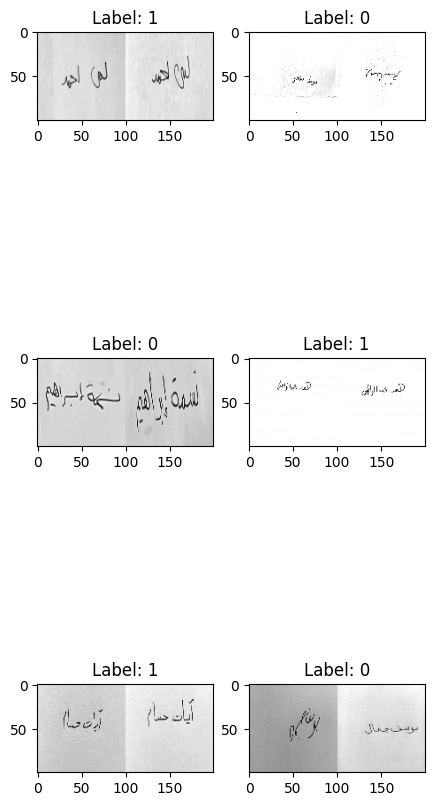

In [11]:
import matplotlib.pyplot as plt
import random
import keras
fig, axes = plt.subplots(3, 2, figsize=(5, 12))
for i in range(6):
    ax = axes[i // 2, i % 2]
    img_idx = random.randint(0, len(siamese_train_pairs))
    ax.imshow(keras.ops.concatenate([siamese_train_pairs[img_idx][0], siamese_train_pairs[img_idx][1]], axis=1), cmap='gray')
    ax.set_title("Label: {}".format(siamese_train_labels[img_idx]))

In [12]:
siamese_train_pairs.shape

(2964, 2, 100, 100, 1)

# Build Siamese Model

In [13]:
# Step 5: Build Siamese network model
def create_siamese_model(input_shape):
    input_anchor = Input(shape=input_shape)
    input_positive = Input(shape=input_shape)

    # Shared convolutional base
    conv_base = tf.keras.Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu')
    ])
    encoded_anchor = conv_base(input_anchor)
    encoded_positive = conv_base(input_positive)
    distance = Lambda(lambda x: tf.abs(x[0] - x[1]))([encoded_anchor, encoded_positive])
    output = Dense(1, activation='sigmoid')(distance)
    model = Model(inputs=[input_anchor, input_positive], outputs=output)
    return model

siamese_model = create_siamese_model((100, 100, 1))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


# fit the model

In [14]:
siamese_model.compile(optimizer=Adam(), loss=binary_crossentropy, metrics=['accuracy'])
siamese_model.fit([siamese_train_pairs[:, 0], siamese_train_pairs[:, 1]], siamese_train_labels, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
 9/75 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4923 - loss: 7.2951

I0000 00:00:1712651075.339237      69 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1712651075.361350      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5526 - loss: 3.0628

W0000 00:00:1712651079.158943      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.5535 - loss: 3.0410 - val_accuracy: 0.7639 - val_loss: 0.5209
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8198 - loss: 0.4097 - val_accuracy: 0.8280 - val_loss: 0.4124
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9435 - loss: 0.1922 - val_accuracy: 0.8752 - val_loss: 0.3528
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9626 - loss: 0.1473 - val_accuracy: 0.9174 - val_loss: 0.2839
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9536 - loss: 0.1670 - val_accuracy: 0.9073 - val_loss: 0.3109
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9836 - loss: 0.0663 - val_accuracy: 0.9342 - val_loss: 0.1980
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9937 - loss: 0.0340 - val_accuracy: 0.9528 - val_loss: 0.1579
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9980 - loss: 0.0196 - val_accuracy: 0.9545 - val_loss: 0

# Display Some samples

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9388 - loss: 0.2227
test loss, test acc: [0.22452573478221893, 0.9460916519165039]
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


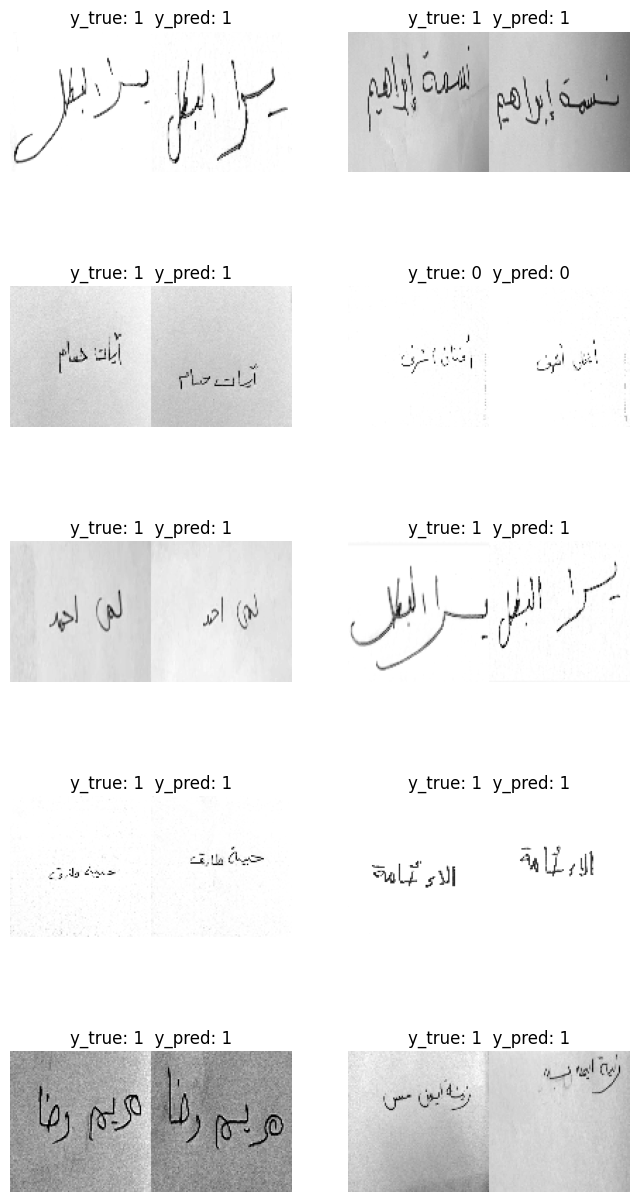

In [15]:
def displayPredictions(x_test,y_test,model):
    results = model.evaluate([x_test[:,0], x_test[:,1]], y_test)
    print("test loss, test acc:", results)
    predictions = model.predict([x_test[:,0], x_test[:,1]])
    fig, axes = plt.subplots(5, 2, figsize=(8, 16))
    for i in range(10):
        ax = axes[i // 2, i % 2]
        img_idx = random.randint(0, len(x_test))
        ax.imshow(keras.ops.concatenate([x_test[img_idx][0], x_test[img_idx][1]], axis=1), cmap='gray')
        ax.set_title("y_true: {}".format(y_test[img_idx]) + "  y_pred: {}".format(int(predictions[img_idx][0]>0.5)))
        ax.axis('off')
    return predictions
model1Predictions=displayPredictions(siamese_test_pairs,siamese_test_labels,siamese_model)

# Model Evaluation

In [16]:
# Step 7: Evaluate the model
siamese_model.evaluate([siamese_test_pairs[:, 0], siamese_test_pairs[:, 1]], siamese_test_labels)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9388 - loss: 0.2227


[0.22452573478221893, 0.9460916519165039]

In [17]:
from sklearn.metrics import confusion_matrix, classification_report
def createReport(y_test,predictions):
    binary_predictions = (predictions > 0.5).astype(int)
    conf_matrix = confusion_matrix(y_test, binary_predictions)
    print("Confusion Matrix:")
    print(conf_matrix)
    class_report = classification_report(y_test, binary_predictions)
    print("Classification Report:")
    print(class_report)
createReport(siamese_test_labels,model1Predictions)

Confusion Matrix:
[[360  33]
 [  7 342]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       393
           1       0.91      0.98      0.94       349

    accuracy                           0.95       742
   macro avg       0.95      0.95      0.95       742
weighted avg       0.95      0.95      0.95       742

